In [1]:
import torch
from torchtext import data,datasets
import random
import torch.nn as nn
from torch import optim
import numpy as np
import time
import copy

**Step 1 : Instantiate Text and Label field**

In [2]:
SEED = 4

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#create text field to store textdata
#tokenize text data with "spacy" tokenizer
TEXT = data.Field(tokenize = 'spacy')
#create label field to store labels in float
LABEL = data.LabelField(dtype = torch.float)

**Step 2 : Create data split**

In [3]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print(type(train_data))
print(len(train_data))
print(len(test_data))

<class 'torchtext.datasets.imdb.IMDB'>
25000
25000


In [4]:
#create train and validation split from train data
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
#check size of splits
print(len(train_data))
print(len(valid_data))
print(len(test_data))

17500
7500
25000


**Step 3 : Build vocabulary from training data**

In [5]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

print("Vocabulary size : ",len(TEXT.vocab))
print("No of different labels : ",len(LABEL.vocab))

Vocabulary size :  10002
No of different labels :  2


In [6]:
#print most 20 frequently occured tokens in the corpus
print(TEXT.vocab.freqs.most_common(20))

[('the', 203653), (',', 192410), ('.', 165777), ('and', 109844), ('a', 109404), ('of', 100996), ('to', 94003), ('is', 76197), ('in', 61428), ('I', 54258), ('it', 53583), ('that', 49228), ('"', 43922), ("'s", 43359), ('this', 42349), ('-', 36831), ('/><br', 35639), ('was', 35187), ('as', 30351), ('with', 29982)]


In [7]:
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
defaultdict(<function _default_unk_index at 0x7fcdd1758158>, {'neg': 0, 'pos': 1})


**Step 4 : Create dataloader**

In [8]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader, valloader, testloader = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

**Step 5 : Build model**

In [10]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm=nn.LSTM(embedding_dim, 
                           hidden_dim[0], 
                           num_layers=1, 
                           bidirectional=True, 
                           )
        self.lstm2=nn.LSTM(hidden_dim[0]*2,hidden_dim[1],
                           num_layers=1,bidirectional=True)
        self.fc = nn.Linear(hidden_dim[1]*2, 16)
        self.fc2=nn.Linear(16,output_dim)
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output,_ = self.lstm(embedded)
        _, (hidden,cell) = self.lstm2(output)
        #print(output.shape,hidden.shape,cell.shape)
        #here the return fc have output dim=(batch_size,1)
        hidden=torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        ans=self.fc(hidden)
        ans=self.fc2(ans)
        return ans

**Step 5 : Instanstiate Loss function, Optimizer, Model**

In [11]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 64
HIDDEN_DIM = [32,64]
OUTPUT_DIM = 1

In [12]:
def evaluation_gpu(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [13]:
def fit_gpu(trainloader,valloader,model,opt,loss_fn,epochs=25):
        #callback=StopatLossValue()
        time0=time.time()
        trainloss=[]
        valloss=[]
        trainacclist=[]
        valacclist=[]
        min_valloss=10000000.0000000
        min_trainloss=10000000.0000000
        max_valacc=0.0
        max_trainacc=0.0
        
        for epoch in range(epochs):
            runningtrain_loss=0
            runningval_loss=0
            #init_fn()
            for i, data in enumerate(trainloader, 0):

                #inputs, labels = data
                #inputs=inputs.to(device)
                #labels=labels.to(device)

                #forward pass
                predtrain=model(data.text).squeeze(1)
                loss = loss_fn(predtrain, data.label)
                trainacc=evaluation_gpu(predtrain,data.label)
                #backward and optimize
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                
                runningtrain_loss += loss.item()
            #init_fn()
            for i, data in enumerate(valloader,0):
                #inputs, labels = data
                #inputs=inputs.to(device)
                #labels=labels.to(device)

                #forward pass
                predval=model(data.text).squeeze(1)
                loss = loss_fn(predval, data.label)
                valacc=evaluation_gpu(predval,data.label)

                runningval_loss += loss.item()
            avgval_loss=runningval_loss/len(valloader)
            avgtrain_loss=runningtrain_loss/len(trainloader)
            if (avgval_loss<min_valloss):
                min_valloss=avgval_loss    
                vallossmodel=copy.deepcopy(model.state_dict())
            if (avgtrain_loss<min_trainloss):
                min_trainloss=avgtrain_loss
                trainlossmodel=copy.deepcopy(model.state_dict())
            trainacclist.append(trainacc)
            valacclist.append(valacc)
            if (trainacc>max_trainacc):
                max_trainacc=trainacc
                trainaccmodel=copy.deepcopy(model.state_dict())
            if (valacc>max_valacc):
                max_trainacc=valacc
                valaccmodel=copy.deepcopy(model.state_dict())      
            print("Minimum training Loss :",min_trainloss,"| Minimum validation Loss :",min_valloss) 
            print("Epoch {} - Training loss: {}".format(epoch,avgtrain_loss ),"| validation loss: {}".format(avgval_loss))    
            print('Epoch: %d/%d, Train acc: %0.2f' % (epoch, epochs-1,trainacc ),'| val acc: %0.2f' % (valacc))
            print('------------------------------------------------------------------------------------------')
            trainloss.append(avgtrain_loss)       
            valloss.append(avgval_loss)
            #vis.line(Y=avgtrain_loss, opts=dict(showlegend=True))
        print("Training Time(in minutes) =",(time.time()-time0)/60)    
        return vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist

In [14]:
model = LSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(device)
opt = optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()
vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist=fit_gpu(trainloader,valloader,model,opt,loss_fn)

Minimum training Loss : 0.6703374062748234 | Minimum validation Loss : 0.6336248009762866
Epoch 0 - Training loss: 0.6703374062748234 | validation loss: 0.6336248009762866
Epoch: 0/24, Train acc: 0.56 | val acc: 0.75
------------------------------------------------------------------------------------------
Minimum training Loss : 0.5785146691790447 | Minimum validation Loss : 0.5646931464367725
Epoch 1 - Training loss: 0.5785146691790447 | validation loss: 0.5646931464367725
Epoch: 1/24, Train acc: 0.59 | val acc: 0.67
------------------------------------------------------------------------------------------
Minimum training Loss : 0.5785146691790447 | Minimum validation Loss : 0.5646931464367725
Epoch 2 - Training loss: 0.6903955781699534 | validation loss: 0.6860619844274318
Epoch: 2/24, Train acc: 0.53 | val acc: 0.58
------------------------------------------------------------------------------------------
Minimum training Loss : 0.5785146691790447 | Minimum validation Loss : 0.564

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = evaluation_gpu(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [16]:
model.load_state_dict(valaccmodel)
test_loss, test_acc = evaluate(model, testloader, loss_fn)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.743 | Test Acc: 85.68%


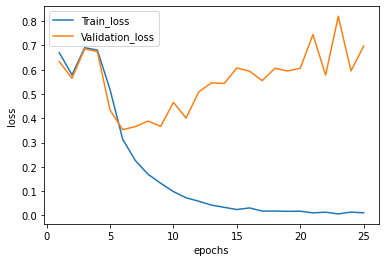

In [17]:
import matplotlib.pyplot as plt

epochs=len(trainloss)
plt.plot([i for i in range(1,epochs+1)],trainloss,label="Train_loss")
plt.plot([i for i in range(1,epochs+1)],valloss,label="Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

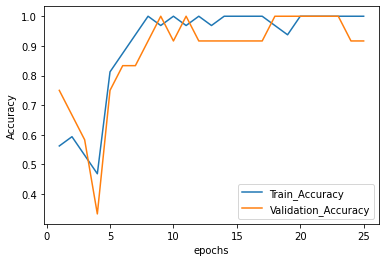

In [18]:
plt.plot([i for i in range(1,epochs+1)],trainacclist,label="Train_Accuracy")
plt.plot([i for i in range(1,epochs+1)],valacclist,label="Validation_Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()